In [761]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


##### Importing model for forecasting --> using xgboost

In [762]:
import xgboost as xgb

In [763]:
df=pd.read_excel('ktm_air_quality_index.xlsx')

In [764]:
df.head()

,Unnamed: 0,date,parameter,value,unit,remark
0,1,2017-03-03,pm25,115.500000,µg/m³,Unhealty
1,2,2017-03-04,pm25,126.658333,µg/m³,Unhealty
2,3,2017-03-09,pm25,89.115000,µg/m³,Sensetive Group
3,4,2017-03-10,pm25,64.720000,µg/m³,Good
4,5,2017-03-11,pm25,24.877083,µg/m³,Good


In [765]:
df.tail()

,Unnamed: 0,date,parameter,value,unit,remark
1376,1377,2021-03-09,pm25,63.973684,µg/m³,Moderate
1377,1378,2021-03-10,pm25,80.000000,µg/m³,Good
1378,1379,2021-03-11,pm25,57.020833,µg/m³,Unhealty
1379,1380,2021-03-12,pm25,82.062500,µg/m³,Moderate
1380,1381,2021-03-13,pm25,59.500000,µg/m³,Moderate


In [766]:
df.drop_duplicates()

,Unnamed: 0,date,parameter,value,unit,remark
0,1,2017-03-03,pm25,115.500000,µg/m³,Unhealty
1,2,2017-03-04,pm25,126.658333,µg/m³,Unhealty
2,3,2017-03-09,pm25,89.115000,µg/m³,Sensetive Group
3,4,2017-03-10,pm25,64.720000,µg/m³,Good
4,5,2017-03-11,pm25,24.877083,µg/m³,Good
...,...,...,...,...,...,...
1376,1377,2021-03-09,pm25,63.973684,µg/m³,Moderate
1377,1378,2021-03-10,pm25,80.000000,µg/m³,Good
1378,1379,2021-03-11,pm25,57.020833,µg/m³,Unhealty
1379,1380,2021-03-12,pm25,82.062500,µg/m³,Moderate


In [767]:
df.drop(['Unnamed: 0','remark','parameter','unit'], axis=1,inplace=True)

In [768]:
df.rename(columns={'value':'pm2.5'},inplace=True)

In [769]:
df.head()

,date,pm2.5
0,2017-03-03,115.500000
1,2017-03-04,126.658333
2,2017-03-09,89.115000
3,2017-03-10,64.720000
4,2017-03-11,24.877083


In [770]:
df=df.set_index('date')

In [771]:
df.head()

,pm2.5
date,
2017-03-03,115.500000
2017-03-04,126.658333
2017-03-09,89.115000
2017-03-10,64.720000
2017-03-11,24.877083


In [772]:
# changing the data type for index to datetime
df.index=pd.to_datetime(df.index)

In [773]:
color_palette=sns.color_palette()

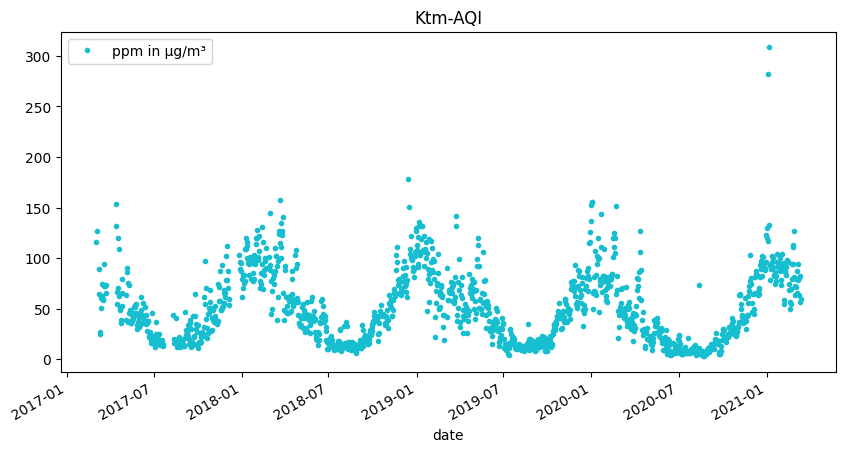

In [774]:
df.plot(style='.',figsize=(10,5),color=color_palette[9],title='Ktm-AQI')
plt.legend(['ppm in µg/m³'])
plt.show()

#### Train / Test split

In [775]:
#spliting to train and test split --> training data is upto 2020-01 and test data is after 2020-01
train = df.loc[df.index < '2020-01-01']
test = df.loc[df.index >= '2020-01-01']

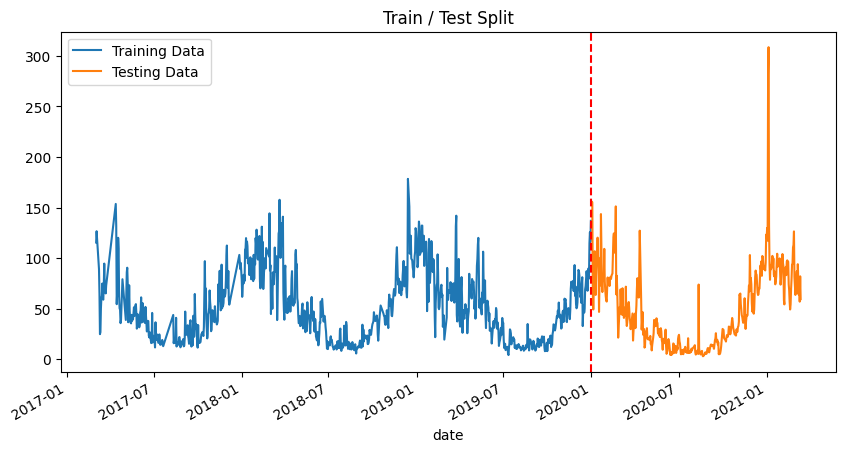

In [776]:
#plotting the train and test data
fig, ax = plt.subplots(figsize=(10,5))
train.plot(ax=ax, label='Training Set',title='Train / Test Split')
test.plot(ax=ax,label='Testing Set')
# add a line to show the split area
ax.axvline('2020-01-01',color='red',ls='--')
ax.legend(['Training Data','Testing Data'])
plt.show()

<Axes: title={'center': 'Monthly'}, xlabel='date'>

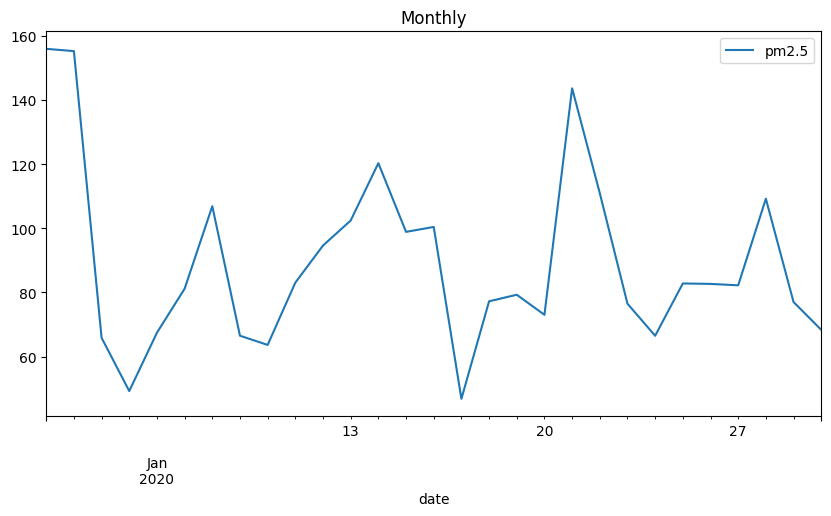

In [777]:
df.loc[(df.index > '2020-01-01')&(df.index < '2020-01-31')].plot(figsize=(10,5),title="Monthly")

#### Feature creation on time series data

In [778]:
# create time series features based on time series index
def make_some_feature(df):
    df= df.copy()
    df['daily']= df.index.day
    df['weekly']= df.index.dayofweek
    df['quarterly']= df.index.quarter
    df['monthly']=df.index.month
    df['yearly']=df.index.year 
    return df

In [779]:
df_featured = make_some_feature(df)
df_featured

,pm2.5,daily,weekly,quarterly,monthly,yearly
date,,,,,,
2017-03-03,115.500000,3,4,1,3,2017
2017-03-04,126.658333,4,5,1,3,2017
2017-03-09,89.115000,9,3,1,3,2017
2017-03-10,64.720000,10,4,1,3,2017
2017-03-11,24.877083,11,5,1,3,2017
...,...,...,...,...,...,...
2021-03-09,63.973684,9,1,1,3,2021
2021-03-10,80.000000,10,2,1,3,2021
2021-03-11,57.020833,11,3,1,3,2021


### Feature / Target Relationship

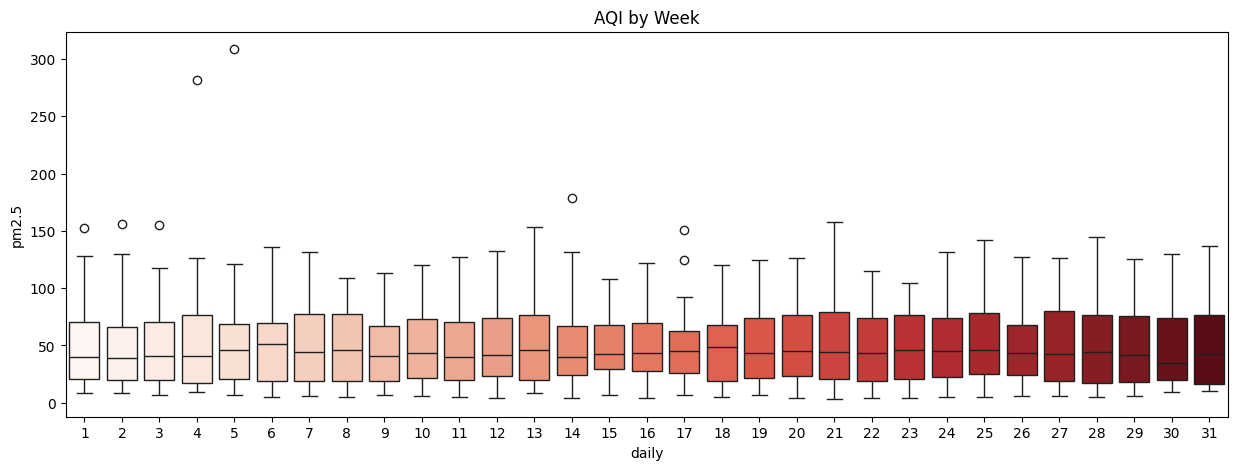

In [780]:
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(data=df_featured, x='daily', y='pm2.5',palette='Reds', hue='daily', legend=False)
ax.set_title('AQI by Week')
plt.show()

## Modelling
Creating a regression model using xgb

In [781]:
train = make_some_feature(train)
test = make_some_feature(test)

In [782]:
# What are the features?
df_featured.columns
FEATURES = ['daily', 'weekly', 'quarterly', 'monthly', 'yearly']
TARGET = ['pm2.5']

In [783]:
# Creating a training and testing data set
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [784]:
# nEstimator seta the number of trees the boosted tree algorithm will create
# early_stopping_rounds determine when the model stops if there is no improvement
# reducing the learning rate reduce the chance of overfitting
# verbose => print out the training and validation score
model = xgb.XGBRegressor(nEstimator=1000, 
early_stopping_rounds=50,
learning_rate=0.01)
model.fit(X_train, y_train,eval_set=[(X_train,y_train), (X_test,y_test)],
verbose=10)

[0]	validation_0-rmse:32.34733	validation_1-rmse:38.91397
[10]	validation_0-rmse:29.92081	validation_1-rmse:36.96657
[20]	validation_0-rmse:27.72531	validation_1-rmse:35.31006
[30]	validation_0-rmse:25.76924	validation_1-rmse:33.92371
[40]	validation_0-rmse:24.01698	validation_1-rmse:32.79133
[50]	validation_0-rmse:22.44276	validation_1-rmse:31.84266
[60]	validation_0-rmse:21.04649	validation_1-rmse:31.05667
[70]	validation_0-rmse:19.80548	validation_1-rmse:30.38504
[80]	validation_0-rmse:18.70436	validation_1-rmse:29.83022
[90]	validation_0-rmse:17.74665	validation_1-rmse:29.35096
[99]	validation_0-rmse:16.99174	validation_1-rmse:28.99102


C:\Users\shaky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:49:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "nEstimator" } are not used.

  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, nEstimator=1000, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

### Feature importance

In [785]:
model.feature_importances_

array([0.02444842, 0.01487933, 0.14722961, 0.786389  , 0.02705369],
      dtype=float32)

In [786]:
imp = pd.DataFrame(data=model.feature_importances_,
index=model.feature_names_in_,
columns=['importance'])

In [787]:
imp.sort_values('importance')


,importance
weekly,0.014879
daily,0.024448
yearly,0.027054
quarterly,0.147230
monthly,0.786389


<Axes: title={'center': 'Feature Importance'}>

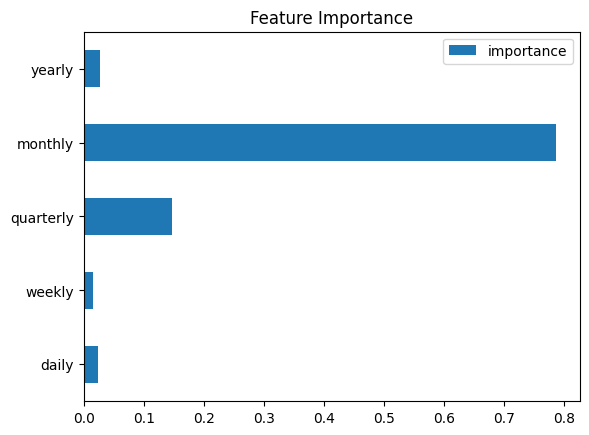

In [788]:
# kind = barh -> plot a horizontal bar plot
imp.plot(kind='barh', title='Feature Importance')

# Forcasting the data for the test data

In [789]:
model.predict(X_test)

array([83.2165  , 83.2165  , 83.2165  , 83.2165  , 88.42566 , 89.28046 ,
       89.28046 , 89.28046 , 89.28046 , 89.28046 , 89.28046 , 89.28046 ,
       89.28046 , 88.88479 , 88.88479 , 88.88479 , 81.48876 , 83.96491 ,
       83.96491 , 83.96491 , 83.96491 , 83.96491 , 64.155464, 71.999985,
       67.76076 , 67.76076 , 76.32366 , 76.32366 , 76.32366 , 76.44022 ,
       76.44022 , 79.22895 , 79.22895 , 72.50498 , 72.50498 , 76.22872 ,
       76.22872 , 57.824215, 57.824215, 57.824215, 58.72912 , 58.898575,
       58.898575, 58.898575, 58.898575, 59.126877, 59.126877, 58.898575,
       58.898575, 58.898575, 58.898575, 58.898575, 59.126877, 59.126877,
       61.164112, 61.164112, 51.143806, 51.143806, 51.143806, 56.11815 ,
       63.789337, 59.31304 , 58.803864, 63.28016 , 63.28016 , 63.28016 ,
       61.845036, 61.845036, 62.142384, 62.74994 , 62.919395, 62.919395,
       62.919395, 63.147697, 63.147697, 62.919395, 62.919395, 62.919395,
       62.919395, 62.919395, 63.147697, 63.147697, 

In [790]:
test['predicted val'] = model.predict(X_test)

In [791]:
test

,pm2.5,daily,weekly,quarterly,monthly,yearly,predicted val
date,,,,,,,
2020-01-01,152.717391,1,2,1,1,2020,83.216499
2020-01-02,155.895833,2,3,1,1,2020,83.216499
2020-01-03,155.189189,3,4,1,1,2020,83.216499
2020-01-04,65.883721,4,5,1,1,2020,83.216499
2020-01-05,49.280000,5,6,1,1,2020,88.425659
...,...,...,...,...,...,...,...
2021-03-09,63.973684,9,1,1,3,2021,62.142384
2021-03-10,80.000000,10,2,1,3,2021,62.749939
2021-03-11,57.020833,11,3,1,3,2021,62.919395


In [792]:
df_copy =df.copy()

In [793]:
df_copy=df_copy.merge(test[['predicted val']], how='left',left_index=True,right_index=True)

In [794]:
# since the prediction was done on data from 2020 onwords the data before that has NaN as predicted value
df_copy

,pm2.5,predicted val
date,,
2017-03-03,115.500000,NaN
2017-03-04,126.658333,NaN
2017-03-09,89.115000,NaN
2017-03-10,64.720000,NaN
2017-03-11,24.877083,NaN
...,...,...
2021-03-09,63.973684,62.142384
2021-03-10,80.000000,62.749939
2021-03-11,57.020833,62.919395


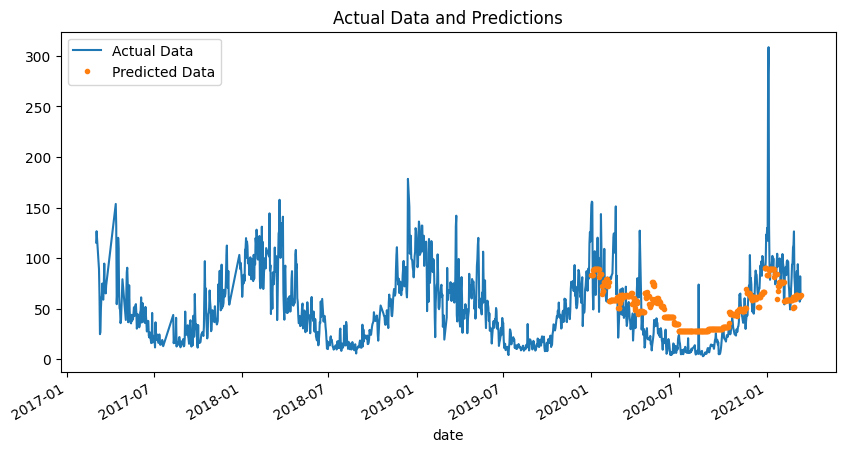

In [795]:
#Plotting predictions
ax = df_copy[['pm2.5']].plot(figsize=(10,5))
df_copy['predicted val'].plot(ax=ax, style='.')
plt.legend(['Actual Data','Predicted Data'])
ax.set_title('Actual Data and Predictions')
plt.show()

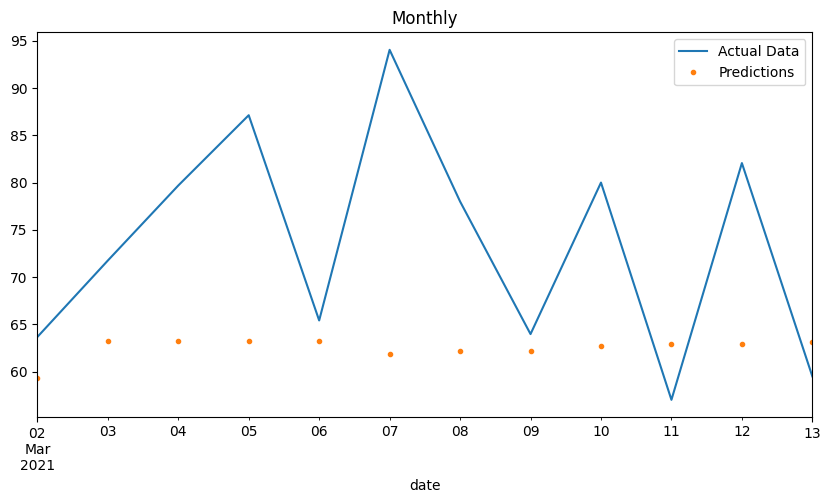

In [796]:
ax = df_copy.loc[(df_copy.index > '2021-03-01')&(df_copy.index < '2021-03-30')]['pm2.5']\
.plot(figsize=(10,5),title="Monthly")

df_copy.loc[(df_copy.index > '2021-03-01')&(df_copy.index < '2021-03-30')]['predicted val']\
.plot(style='.')
plt.legend(['Actual Data','Predictions'])
plt.show()

In [797]:
df.head()

,pm2.5
date,
2017-03-03,115.500000
2017-03-04,126.658333
2017-03-09,89.115000
2017-03-10,64.720000
2017-03-11,24.877083


## Outlier Analysis

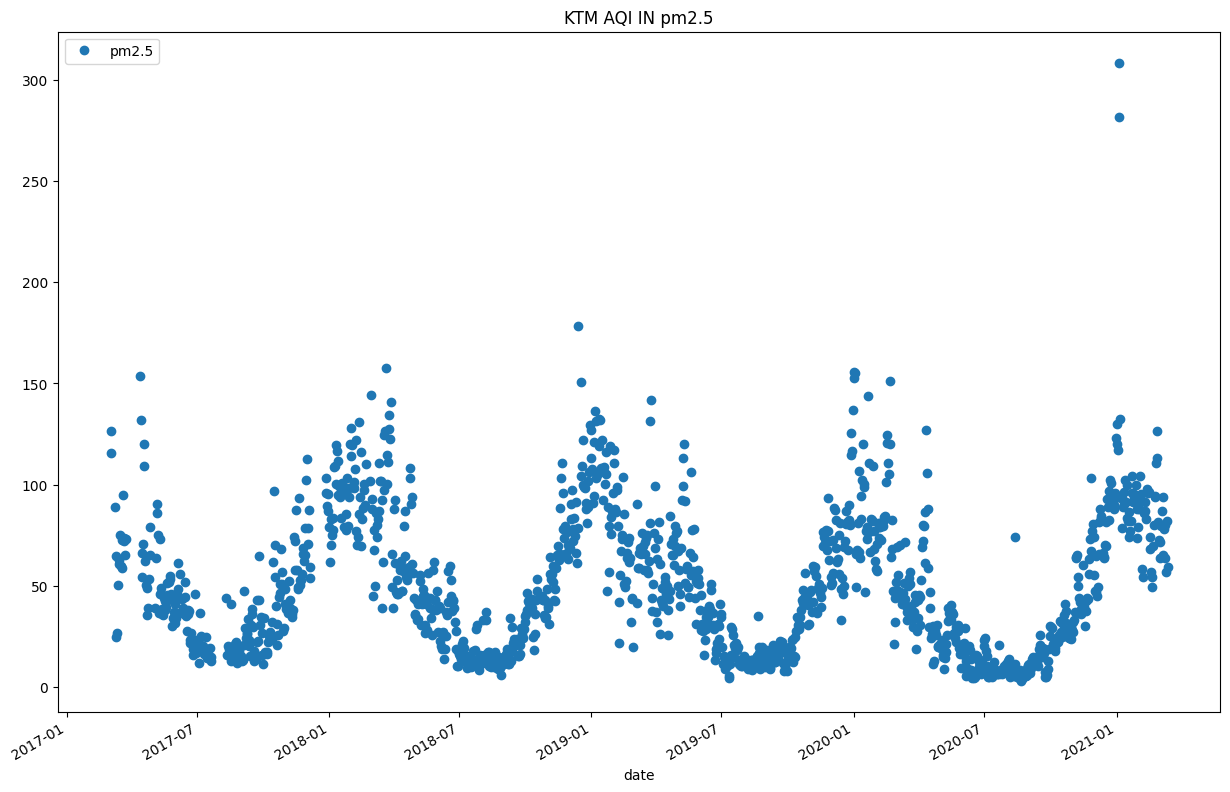

In [798]:
df.plot(style='o',
figsize=(15,10),
color=color_palette[0],
title='KTM AQI IN pm2.5')
plt.show()

<Axes: ylabel='Frequency'>

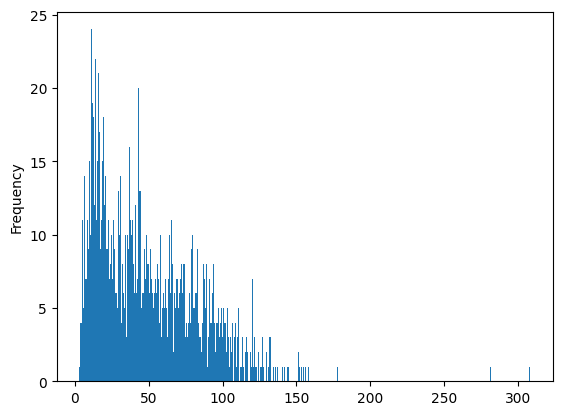

In [799]:
df['pm2.5'].plot(kind='hist', bins=500)
#bins represent equal intervals into which the data is divided

In [800]:
# finding extreme outliers
df.query('`pm2.5` > 175')


,pm2.5
date,
2018-12-14,178.400000
2021-01-04,281.666667
2021-01-05,308.604167


<Axes: xlabel='date'>

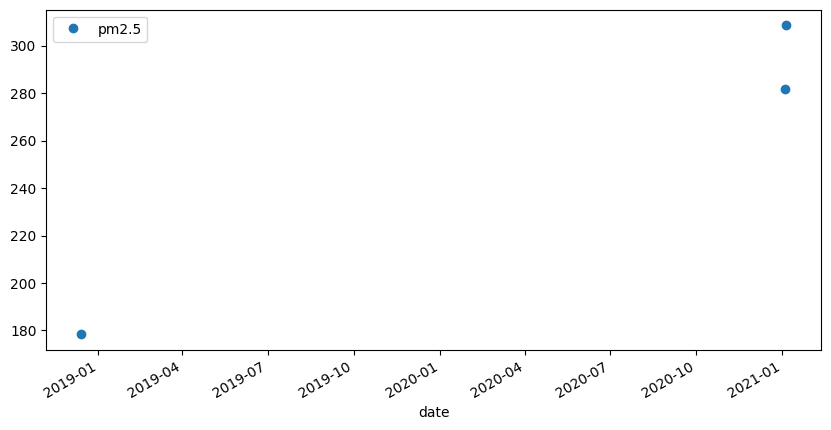

In [801]:
df.query('`pm2.5` > 175').plot(figsize=(10,5), style="o")

<Axes: xlabel='date'>

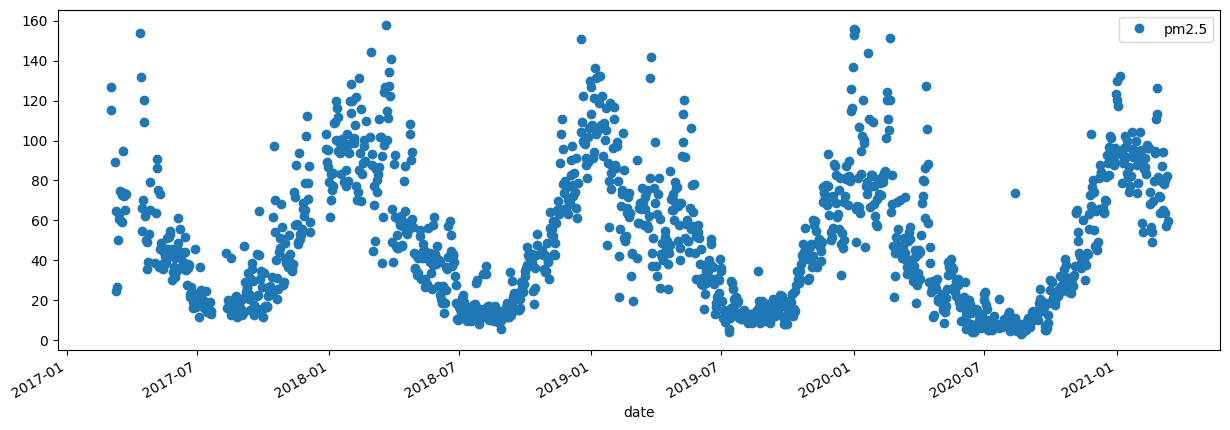

In [802]:
df =df.query('`pm2.5` < 175').copy()
df.plot(figsize=(15,5), style='o')

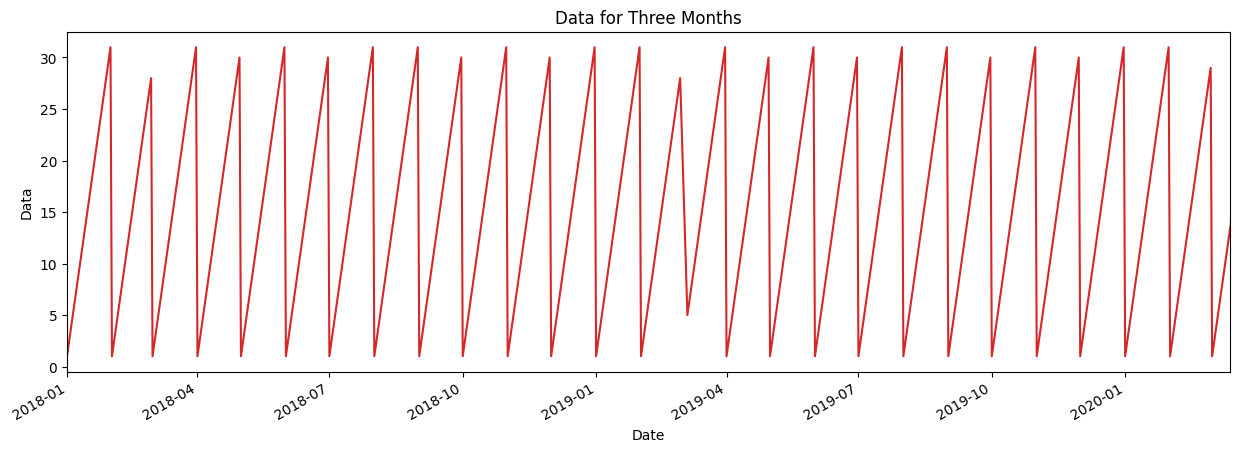

In [845]:
df['daily'].plot(figsize=(15,5), color=color_palette[3])
plt.xlim('2018-01-01', '2020-03-13')
plt.xlabel('Date')
plt.ylabel('Data')
plt.title('Data for Three Months')
plt.show()

# Time series Cross Validation
Using sklearn timeseries split

In [803]:
from sklearn.model_selection import TimeSeriesSplit

In [804]:
#TimeSeriesSplit?

In [805]:
time_series_split = TimeSeriesSplit(n_splits=5)
#test_size is set to 365*3 because the data is in daily basis and then we 
#want to predict till 3 years in the future
#gap = 1 because the data set is on daily basis

In [806]:
# index of the dataframe must be sorted for the time series split to work
df =df.sort_index()

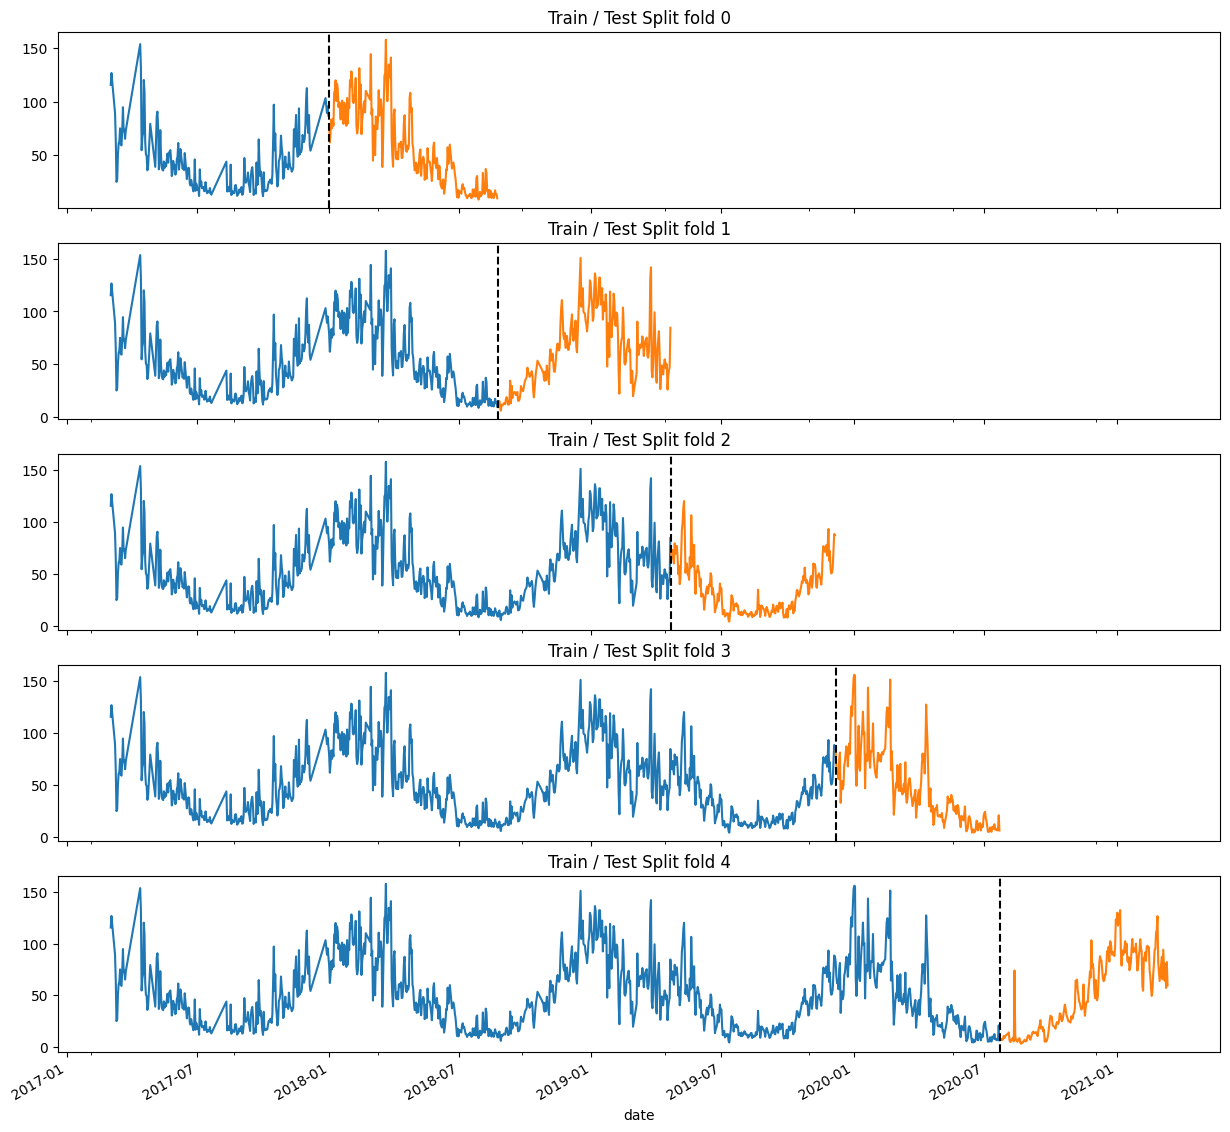

In [807]:
fig, axs = plt.subplots(5,1,figsize=(15,15), sharex=True)

fold = 0
for train_idx, val_idx in time_series_split.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['pm2.5'].plot(ax=axs[fold],
    label='Training Set',
    title=f'Train / Test Split fold {fold}')
    test['pm2.5'].plot(ax=axs[fold],
    label='Testing Set')
    axs[fold].axvline(test.index.min(),color='black',ls='--')
    fold += 1
plt.show()


## Forecasting Horizon
How far in the future to predict?

In [808]:
# create time series features based on time series index
def make_some_feature(df):
    df= df.copy()
    df['daily']= df.index.day
    df['weekly']= df.index.dayofweek
    df['quarterly']= df.index.quarter
    df['monthly']=df.index.month
    df['yearly']=df.index.year 
    df['day of year']=df.index.dayofyear
    df['week of year']=df.index.isocalendar().week
    return df

df = make_some_feature(df)
df

,pm2.5,daily,weekly,quarterly,monthly,yearly,day of year,week of year
date,,,,,,,,
2017-03-03,115.500000,3,4,1,3,2017,62,9
2017-03-04,126.658333,4,5,1,3,2017,63,9
2017-03-09,89.115000,9,3,1,3,2017,68,10
2017-03-10,64.720000,10,4,1,3,2017,69,10
2017-03-11,24.877083,11,5,1,3,2017,70,10
...,...,...,...,...,...,...,...,...
2021-03-09,63.973684,9,1,1,3,2021,68,10
2021-03-10,80.000000,10,2,1,3,2021,69,10
2021-03-11,57.020833,11,3,1,3,2021,70,10


# Lag Features
look back in the past to x days and use the target value in that many days in the past as a new feature to feed in the model

In [809]:
def add_lags(df):
    mapped_target = df['pm2.5'].to_dict()
    # subtract time delta (some days into the past) from index
    # all multples of 7 ( 364, 728,1092) to get easy dicision
    df['one Year Lag']=(df.index - pd.Timedelta('364 days')).map(mapped_target)
    df['two Year Lag']=(df.index - pd.Timedelta('728 days')).map(mapped_target)
    df['three Year Lag']=(df.index - pd.Timedelta('1092 days')).map(mapped_target)
    return df

In [810]:
df = add_lags(df)
df.tail()

,pm2.5,daily,weekly,quarterly,monthly,yearly,day of year,week of year,one Year Lag,two Year Lag,three Year Lag
date,,,,,,,,,,,
2021-03-09,63.973684,9,1,1,3,2021,68,10,46.305556,67.239130,101.800000
2021-03-10,80.000000,10,2,1,3,2021,69,10,51.200000,76.279070,102.000000
2021-03-11,57.020833,11,3,1,3,2021,70,10,43.476190,69.434783,92.228571
2021-03-12,82.062500,12,4,1,3,2021,71,10,71.833333,57.666667,38.814815
2021-03-13,59.500000,13,5,1,3,2021,72,10,40.166667,65.687500,61.518519


# Train using Cross Validation

In [811]:
df.columns

Index(['pm2.5', 'daily', 'weekly', 'quarterly', 'monthly', 'yearly',
       'day of year', 'week of year', 'one Year Lag', 'two Year Lag',
       'three Year Lag'],
      dtype='object')

In [812]:
time_series_split = TimeSeriesSplit(n_splits=5)
df = df.sort_index()

preds = []
scores = []

for train_idx, val_idx in time_series_split.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = make_some_feature(train)
    test = make_some_feature(test)

    FEATURES = ['daily', 'weekly', 'quarterly', 'monthly', 'yearly',
       'day of year', 'week of year', 'one Year Lag', 'two Year Lag',
       'three Year Lag']
    TARGET = 'pm2.5'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    cvm = xgb.XGBRegressor(base_score=0.5, booster='gbtree',n_estimators = 1000,early_stopping_rounds=50,objective='reg:linear',max_depth=3,learning_rate=0.01)
    cvm.fit(X_train, y_train,eval_set=[(X_train,y_train), (X_test,y_test)],verbose=100)
    y_pred = cvm.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test,y_pred))
    scores.append(score)


[0]	validation_0-rmse:49.83716	validation_1-rmse:66.83055


[100]	validation_0-rmse:23.21358	validation_1-rmse:35.60546
[200]	validation_0-rmse:14.41162	validation_1-rmse:27.90206


C:\Users\shaky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:49:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:11.59958	validation_1-rmse:27.09801
[353]	validation_0-rmse:10.91951	validation_1-rmse:27.22254
[0]	validation_0-rmse:58.82646	validation_1-rmse:69.48321
[100]	validation_0-rmse:26.58152	validation_1-rmse:31.86547
[200]	validation_0-rmse:17.01739	validation_1-rmse:24.50034


C:\Users\shaky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:49:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[289]	validation_0-rmse:14.28323	validation_1-rmse:24.34434
[0]	validation_0-rmse:62.56572	validation_1-rmse:41.63889
[100]	validation_0-rmse:28.31333	validation_1-rmse:20.78630
[200]	validation_0-rmse:18.24615	validation_1-rmse:15.75950


C:\Users\shaky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:49:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:15.74295	validation_1-rmse:15.16504
[400]	validation_0-rmse:14.91450	validation_1-rmse:15.02768
[488]	validation_0-rmse:14.55186	validation_1-rmse:14.98682
[0]	validation_0-rmse:58.06397	validation_1-rmse:59.47931
[100]	validation_0-rmse:26.55188	validation_1-rmse:27.37669


C:\Users\shaky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:49:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:17.53257	validation_1-rmse:25.07130
[212]	validation_0-rmse:17.06847	validation_1-rmse:25.22165
[0]	validation_0-rmse:58.37613	validation_1-rmse:60.79796
[100]	validation_0-rmse:27.42759	validation_1-rmse:27.80458


C:\Users\shaky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:49:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:18.80167	validation_1-rmse:20.13471
[300]	validation_0-rmse:16.66151	validation_1-rmse:18.11876
[400]	validation_0-rmse:15.84932	validation_1-rmse:17.81260
[500]	validation_0-rmse:15.35073	validation_1-rmse:17.45126
[600]	validation_0-rmse:15.03601	validation_1-rmse:17.48707
[613]	validation_0-rmse:15.00299	validation_1-rmse:17.54142


In [813]:
print(f'Score across folds: {np.mean(scores) :0.4f}')
print(f'Fold scores : {scores}' )

Score across folds: 21.6787
Fold scores : [27.048166724926922, 24.28330310715981, 14.97459088133546, 24.770325227721706, 17.317102378395738]


## Predicting Future
- retrain model on all data
- create an empty dataframe from future data range
- Run the new data through the `make_some_feature()` and `add_lags()` functions

In [814]:
# train the model on the entire dataset
df = make_some_feature(df)

FEATURES = ['daily', 'weekly', 'quarterly', 'monthly', 'yearly',
       'day of year', 'week of year', 'one Year Lag', 'two Year Lag',
       'three Year Lag']
TARGET = 'pm2.5'

X_whole = df[FEATURES]
y_whole = df[TARGET]

prediction_modal = xgb.XGBRegressor(base_score=0.5, booster='gbtree',n_estimators = 200,early_stopping_rounds=50,objective='reg:linear',max_depth=3,learning_rate=0.01)

prediction_modal.fit(X_whole, y_whole,eval_set=[(X_whole,y_whole)],verbose=100)

[0]	validation_0-rmse:58.78553


[100]	validation_0-rmse:27.29944


C:\Users\shaky\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [13:49:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[199]	validation_0-rmse:18.42209


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [815]:
df.index.max()

Timestamp('2021-03-13 00:00:00')

In [816]:
# make new data using pandas
# create a future dataframe
future_date = pd.date_range('2021-03-13','2022-03-01')
future_df = pd.DataFrame(index=future_date)
# indicate it is future date
future_df['isFuture'] = True
df['isFuture'] = False

# merge the future and present dataframes
df_merged = pd.concat([df, future_df])

In [817]:
df_merged = make_some_feature(df_merged)
df_merged = add_lags(df_merged)

In [818]:
future_with_features = df_merged.query('isFuture').copy()

In [819]:
future_with_features

,pm2.5,daily,weekly,quarterly,monthly,yearly,day of year,week of year,one Year Lag,two Year Lag,three Year Lag,isFuture
2021-03-13,NaN,13,5,1,3,2021,72,10,40.166667,65.687500,61.518519,True
2021-03-14,NaN,14,6,1,3,2021,73,10,32.958333,71.875000,97.551724,True
2021-03-15,NaN,15,0,1,3,2021,74,11,36.913043,73.500000,124.375000,True
2021-03-16,NaN,16,1,1,3,2021,75,11,49.750000,75.166667,126.580645,True
2021-03-17,NaN,17,2,1,3,2021,76,11,54.083333,57.958333,157.739130,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-25,NaN,25,4,1,2,2022,56,8,113.071429,43.903226,NaN,True
2022-02-26,NaN,26,5,1,2,2022,57,8,126.470588,51.625000,NaN,True
2022-02-27,NaN,27,6,1,2,2022,58,8,81.545455,47.791667,NaN,True
2022-02-28,NaN,28,0,1,2,2022,59,9,72.458333,69.208333,NaN,True


### Predict the future

In [820]:
future_with_features['prediction']=prediction_modal.predict(future_with_features[FEATURES])

In [832]:
future_with_features.head()

,pm2.5,daily,weekly,quarterly,monthly,yearly,day of year,week of year,one Year Lag,two Year Lag,three Year Lag,isFuture,prediction
2021-03-13,NaN,13,5,1,3,2021,72,10,40.166667,65.687500,61.518519,True,57.833111
2021-03-14,NaN,14,6,1,3,2021,73,10,32.958333,71.875000,97.551724,True,55.094860
2021-03-15,NaN,15,0,1,3,2021,74,11,36.913043,73.500000,124.375000,True,55.094860
2021-03-16,NaN,16,1,1,3,2021,75,11,49.750000,75.166667,126.580645,True,57.876087
2021-03-17,NaN,17,2,1,3,2021,76,11,54.083333,57.958333,157.739130,True,57.876087


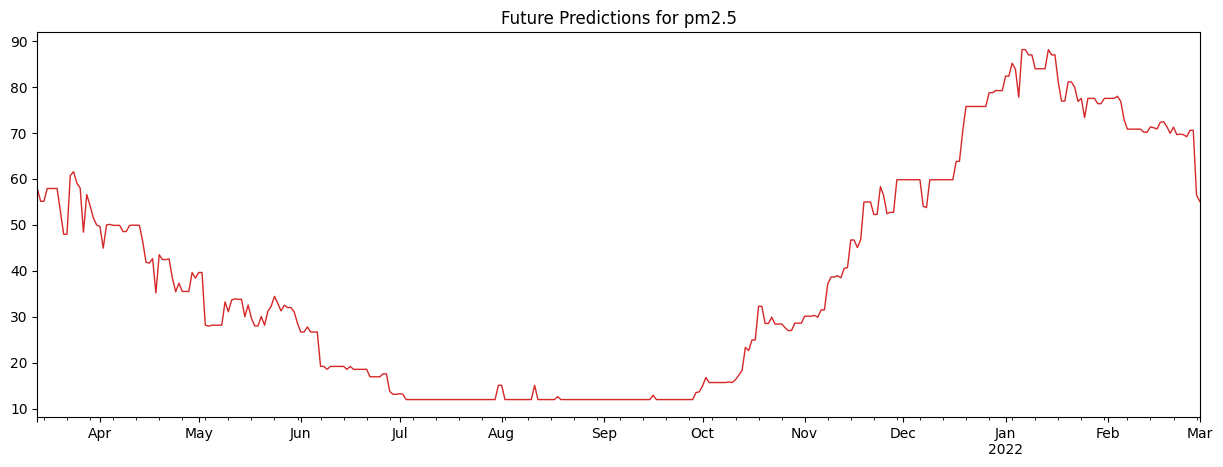

In [821]:
future_with_features['prediction'].plot(figsize=(15,5),
                                        color=color_palette[3],
                                        ms=1,
                                        lw=1,
                                        title='Future Predictions for pm2.5')
plt.show()

### Saving the moeel for future so it doesn't have to retrained everytime

In [822]:
prediction_modal.save_model('AQI_predictor_model.json')

<Axes: title={'center': 'Future Predictionsfor pm2.5'}>

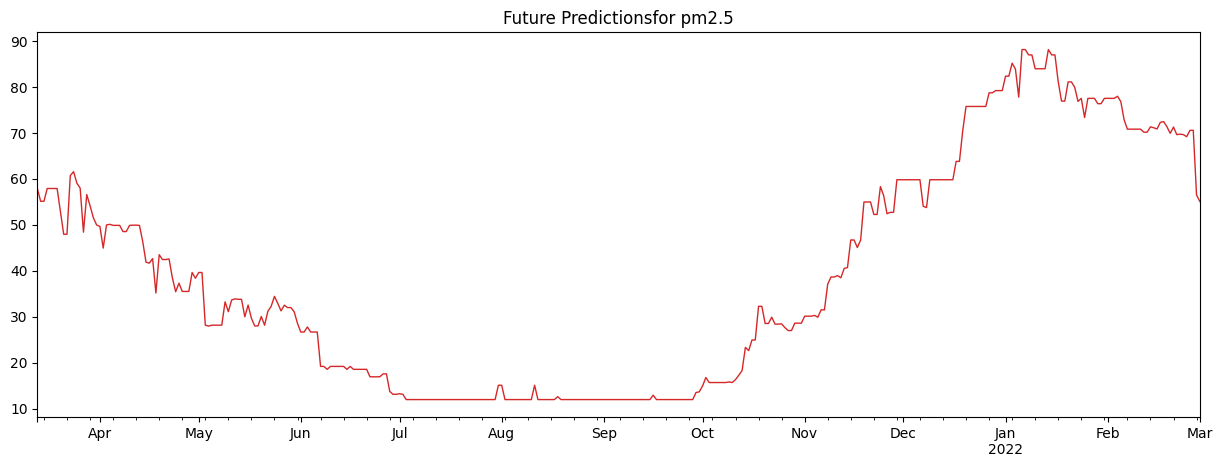

In [823]:
# Loading the model
new_prediction_model = xgb.XGBRegressor()
new_prediction_model.load_model('AQI_predictor_model.json')
future_with_features['prediction']=prediction_modal.predict(future_with_features[FEATURES])
future_with_features['prediction'].plot(figsize=(15,5),
                                        color=color_palette[3],
                                        ms=1,
                                        lw=1,
                                        title='Future Predictionsfor pm2.5')